# Neural network from scratch.

Based on YSDA Deep Learning course materials.

https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework01/homework_modules.ipynb

We will implement most common layers using `numpy` for matrix operations. 

The file `modules.py` contains the abstract classes for **module**, **criterion** and **sequential** model class.

**Module** is an abstract class which defines the fundamental methods required for training a neural network.

**Criterion** class implements a container which can be used to score the models answers. 

**Sequential** class implements a container which processes `input` data sequentially. 


#### Tips and tricks
Original `numpy` operation are preferable to the overloaded ones (`+`, `*`, `-`, etc. vs `np.add`, `np.multiply`, `np.substract`). They are less prone to excess memory usage and seem unified with tensor frameworks.

*Example:*

```
a = np.zeros_like(arr1)

a = arr1 + arr2 #  bad, we reallocate memory for the result of + operation

a = np.zeros_like(arr1)

np.add(arr1, arr2, out=a) #  good, we use same allocated memory, no need to call gc
```

But I won't follow that advice ;)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
from modules import Module, Sequential, Criterion

## Impelementing main layers


Let's try to implement some main layers in numpy. 

https://en.wikipedia.org/wiki/Matrix_calculus



[Post about einsum](https://habr.com/ru/post/544498/)

### 1. Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_in`**
- output  **`batch_size x n_out`**

[Backpropagation for a Linear Layer handout](http://cs231n.stanford.edu/handouts/linear-backprop.pdf)

In [3]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D _input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, _input):
        self.output = np.dot(_input, self.W) + self.b
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.dot(gradOutput, self.W.T)
        return self.gradInput
    
    def accGradParameters(self, _input, gradOutput):
        # needs for difficult optimizers
        # self.gradW = ... ; self.gradb = ...
        self.gradW += np.dot(_input.T, gradOutput)
        self.gradb += np.sum(gradOutput, axis=0)
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

### 2. SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

[Notes on softmax](https://deepnotes.io/softmax-crossentropy)

In [4]:
# simple einsum example 
p = np.arange(6).reshape((2, 3))
np.einsum('bi,bj->bij', p, p)

array([[[ 0,  0,  0],
        [ 0,  1,  2],
        [ 0,  2,  4]],

       [[ 9, 12, 15],
        [12, 16, 20],
        [15, 20, 25]]])

In [5]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        self.output = np.subtract(_input, _input.max(axis=1, keepdims=True))
        
        self.output = np.exp(self.output)
        self.output = self.output / np.sum(self.output, axis=1, keepdims=True)
        
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # reshape output first
        batch_size = _input.shape[0]
        dim = _input.shape[1]
        
        output_reshaped = self.output.reshape(batch_size, dim, 1)

        # calculate Jacobian matrix for each sample in the batch
        jacobian = output_reshaped * (np.eye(dim) - output_reshaped.transpose((0, 2, 1)))

        # Compute gradient w.r.t input by multiplying Jacobian with gradOutput
        self.gradInput = np.squeeze(np.matmul(jacobian, gradOutput.reshape(batch_size, dim, 1)), axis=-1)
        
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

### 3. Negative LogLikelihood criterion (numerically unstable)
[multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Remember that targets are one-hot encoded. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**## 



In [6]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        self.output = np.subtract(_input, _input.max(axis=1, keepdims=True))
        
        # apply log() function to stabilized inputs
        self.output = np.log(np.exp(self.output)) # or simply np.log(self.output)

        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Gradient of log-softmax is just the difference between one-hot encoded target and softmax probabilities
        self.gradInput = gradOutput - np.exp(self.output)
        
        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

In [7]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, _input):
        self.output = np.maximum(_input, 0)
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.multiply(gradOutput , _input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [8]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, _input):
        # apply LeakyReLU on input
        self.output = np.maximum(_input, self.slope * _input)
        
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Create mask for positive components
        mask = (_input > 0).astype(int)

        # calc grad for LeakyReLU 
        self.gradInput = self.slope * (1 - mask) * gradOutput + mask * gradOutput
        
        return self.gradInput
    
    def __repr__(self):
        return "LeakyReLU"

In [9]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, _input, target): 
        # Check target dims
        assert target.ndim == 2 and target.shape[1] == 2, "Target must have shape (batch_size, 2)"
        
        # Use this trick to avoid numerical errors
        _input_clamp = np.clip(_input, self.EPS, 1 - self.EPS)

        if not isinstance(target, np.ndarray) or target.dtype.kind != 'i':
            target = target.astype('int')

        # sep target on two subarrays
        target1, target2 = target[:, 0], target[:, 1]

        # calculate negative log likelihood loss
        # calc loss for both indices
        loss1 = -np.mean(np.log(_input_clamp[np.arange(len(target1)), target1]))
        loss2 = -np.mean(np.log(_input_clamp[np.arange(len(target2)), target2]))
        
        # Join losses
        self.output = (loss1 + loss2) / 2  # Mean of two losses
        
        # self.output = -np.mean(np.log(_input_clamp[np.arange(target.size), target])) - failed with error

        return self.output

    def updateGradInput(self, _input, target):
        # check target dims
        assert target.ndim == 2 and target.shape[1] == 2, "Target must have shape (batch_size, 2)"
        
        # Use this trick to avoid numerical errors
        _input_clamp = np.clip(_input, self.EPS, 1 - self.EPS)

        if not isinstance(target, np.ndarray) or target.dtype.kind != 'i':
            target = target.astype('int')
    
        # sep target on two arrays
        target1, target2 = target[:, 0], target[:, 1]
        
        # Initialize gradInput with zeros
        self.gradInput = np.zeros_like(_input)

        # update only the elements corresponding to the correct classes
        # update grads for first index
        self.gradInput[np.arange(len(target1)), target1] -= 1 / _input_clamp[np.arange(len(target1)), target1]
        
        # update grads for second index
        self.gradInput[np.arange(len(target2)), target2] -= 1 / _input_clamp[np.arange(len(target2)), target2]
        
        # normilize
        self.gradInput /= (len(target1) + len(target2))
        
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [10]:
# hope on function stability
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, _input, target): 
        # calculate negative log likelihood loss
        self.output = -np.mean(np.log(_input_clamp[np.arange(target.size), target]))

        return self.output

    def updateGradInput(self, _input, target):
        # update only the elements corresponding to the correct classes
        self.gradInput[np.arange(target.size), target] -= 1 / _input_clamp[np.arange(target.size), target]
    
        # Normalize by number of samples
        self.gradInput /= target.size

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [11]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1     

## Toy training example

Use this example to debug your code, just logistic regression. You do not need to change anything here. This code is provided for you to test the layers. 

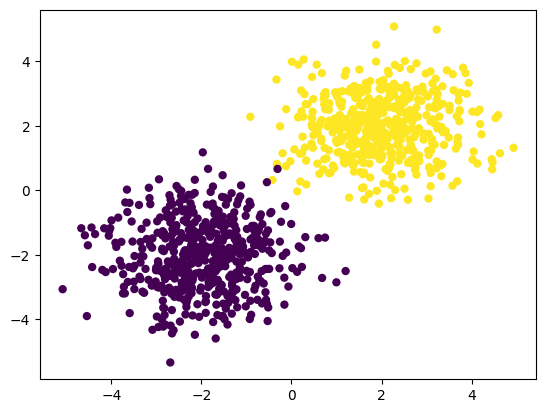

In [12]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [13]:
net = Sequential()
net.add(Linear(2, 2))

net.add(SoftMax())
criterion = ClassNLLCriterionUnstable()

print(net)

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [14]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [15]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

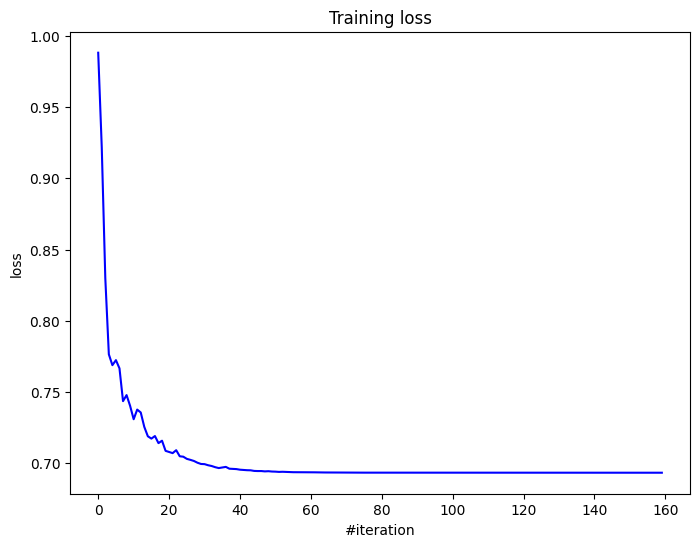

Current loss: 0.693147


In [16]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                   net.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    